# Kaggle Human Protein Atlas - Single Cell Classification Challenge

- https://www.kaggle.com/c/hpa-single-cell-image-classification
- https://github.com/bioimage-io/use-cases/tree/main/case3-devtools

# 1. Setup

### 1a. Load BioImage Models

- https://doi.org/10.5281/zenodo.6200999
- https://doi.org/10.5281/zenodo.6200635

In [1]:
#make sure to activate conda env hpa-app

import bioimageio.core

bioimageio.core.export_resource_package("10.5281/zenodo.6200999", output_path="model-nuc.zip")
nuc_model = bioimageio.core.load_resource_description("model-nuc.zip")

bioimageio.core.export_resource_package("10.5281/zenodo.6200635", output_path="model-cell.zip")
cell_model = bioimageio.core.load_resource_description("model-cell.zip")

site.config.json: 6.57kiB [00:00, 2.10MiB/s]                                    
/opt/anaconda3/envs/hpa-app/lib/python3.10/site-packages/bioimageio/spec/shared/_resolve_source.py:482: UserWarning: Download (6568) does not have expected size (2289).
  warnings.warn(f"Download ({t.n}) does not have expected size ({total_size}).")
collection.json: 235kiB [00:00, 28.5MiB/s]                                      
/opt/anaconda3/envs/hpa-app/lib/python3.10/site-packages/bioimageio/spec/shared/_resolve_source.py:482: UserWarning: Download (234788) does not have expected size (28539).
  warnings.warn(f"Download ({t.n}) does not have expected size ({total_size}).")
rdf.yaml: 3.05kiB [00:00, 1.08MiB/s]                                            
/opt/anaconda3/envs/hpa-app/lib/python3.10/site-packages/bioimageio/spec/shared/_resolve_source.py:482: UserWarning: Download (3053) does not have expected size (1218).
  warnings.warn(f"Download ({t.n}) does not have expected size ({total_size}).")
/opt

### 1b. Create Prediction Pipelines

In [2]:
from bioimageio.core.prediction import predict_with_padding

from xarray import DataArray
from skimage.measure import label
from skimage.segmentation import watershed

pp_nucleus = bioimageio.core.create_prediction_pipeline(bioimageio_model=nuc_model)
pp_cell = bioimageio.core.create_prediction_pipeline(bioimageio_model=cell_model)

### 1c. Prepare Image Dataset

In [3]:
# red microtubule, blue nuclei, green protein, yellow endoplasmic reticulum
channels = ["red", "blue", "green"]
scale_factor = 0.25

In [4]:
hpa_cyto = "921_B9_1_"
hpa_endo = "1876_A7_32_"
hpa_mito = "946_E10_1_"
hpa_nucl = "962_F1_1_"

In [5]:
image_paths = dict()
for hpa in [hpa_cyto, hpa_endo, hpa_mito, hpa_nucl]:
    filepaths = []
    for channel in channels:
        filepaths.append("images/" + hpa + channel + ".png")
    image_paths[hpa] = filepaths

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

from skimage.transform import rescale

In [7]:
def load_image(image_paths, channels, scale_factor):
    image = []
    for chan in channels:
        path = [imp for imp in image_paths if chan in imp]
        path = path[0]
        im = imageio.imread(path)
        im = rescale(im, scale_factor)
        image.append(im[None])
    image = np.concatenate(image, axis=0)
    return image

# 2. Analysis

### 2a. Select Dataset

In [8]:
hpa = hpa_cyto #this is the only thing I have to change for the homework

### 2b. Load Images

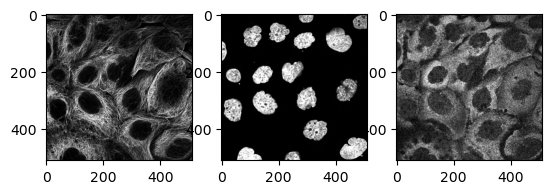

In [67]:
image = load_image(image_paths[hpa], channels, scale_factor)

fig, axes = plt.subplots(1,len(channels))
for i in range(len(channels)):
    axes[i].imshow(image[i,:,:], cmap='gray')

### 2c.Identify Nuclei

In [68]:
axes = cell_model.inputs[0].axes
input_nucleus = DataArray(
    np.concatenate([image[1:2], image[1:2], image[1:2]], axis=0)[None],
    dims=axes
)
padding = {"x": 32, "y": 32}
nuclei_pred = predict_with_padding(pp_nucleus, input_nucleus, padding=padding)[0].values[0]

code/__torch__/torch/nn/functional.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


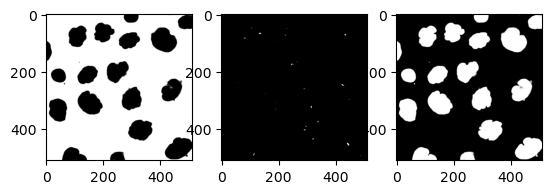

In [69]:
fig, axes = plt.subplots(1,3)
for i in range(3):
    axes[i].imshow(nuclei_pred[i,:,:], cmap='gray')

In [70]:
fg = nuclei_pred[-1]
nuclei = label(fg > 0.5)
ids, sizes = np.unique(nuclei, return_counts=True)

In [71]:
filter_ids = ids[sizes < 250]
nuclei[np.isin(nuclei, filter_ids)] = 0

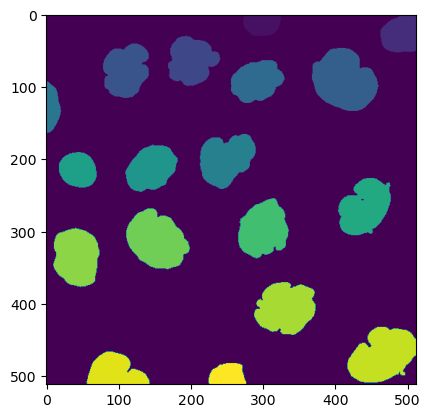

In [72]:
plt.subplots()
plt.imshow(nuclei)

### 2d. Identify Cells

In [73]:
axes = cell_model.inputs[0].axes
input_cells = DataArray(image[None], dims=axes)
cell_pred = predict_with_padding(pp_cell, input_cells, padding=padding)[0].values[0]

code/__torch__/torch/nn/functional.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


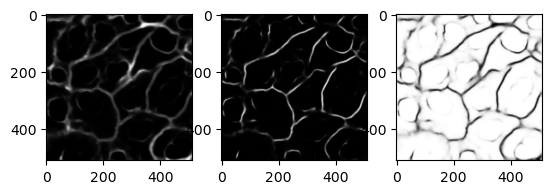

In [74]:
fix, axes = plt.subplots(1,3)
for i in range(3):
    axes[i].imshow(cell_pred[i], cmap='gray')

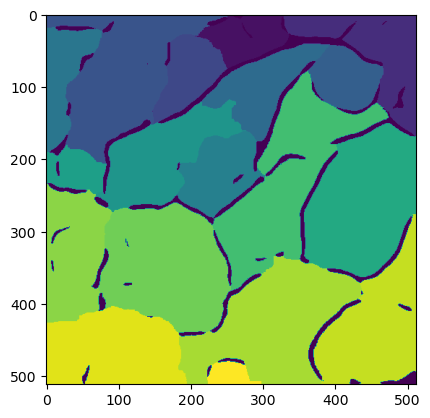

In [75]:
fg, bd = cell_pred[2], cell_pred[1]
cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

In [76]:
ids, sizes = np.unique(cell_seg, return_counts=True)

In [77]:
sizes

array([15266,  5767, 12324,  6840, 22675,  6456,  9445,  6931,  8782,
       14720,  3887, 24313, 24611, 24695, 13322, 24829, 18173, 17462,
        1646])

# 3. Exercises

- Explain the parameters provided to watershed().  What happens when you remove mask?  What happens when you remove markers?
- Compare how well segmentation works for cyto, endo, mito, and nucl.  What types of samples work well?  Not as well?

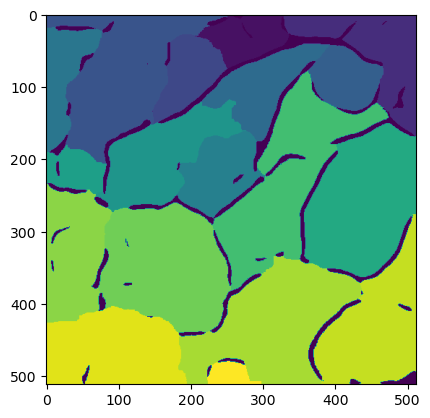

In [78]:
cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

In [66]:
hpa = hpa_cyto

## Question 2a

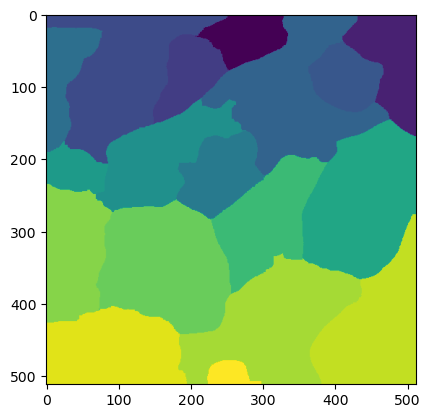

In [22]:
cell_seg = watershed(bd, markers=nuclei)

plt.subplots()
plt.imshow(cell_seg)

If the mask is removed, the segmentation methodoly loses its ability to recognize space in between cells, as the cell mask is no longer present. It only defined cells by the presence of nuclei, and thus makes the cells larger than they should be. Thus, Watershed likely needs a mask and a marker parameter in order to correctley segment the image, a mask to subset the cells, nuclei to differentiate each cell from the others.  

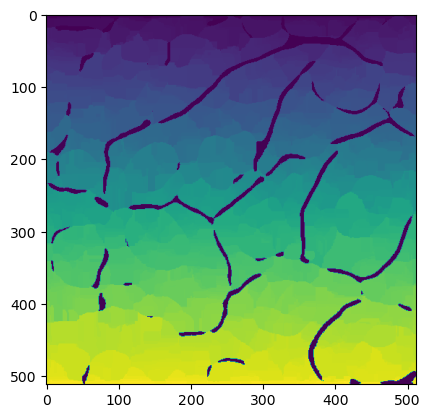

In [21]:
cell_seg = watershed(bd, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

If the nuclei markers are removed, segmentation can't identify nuclei, and thus only the cell mask is present and the segmentation does not work correctly. 

## Question 2b

In [22]:
hpa = hpa_endo

Now, I'll re-run the script from 2b onward, before running the code below: 

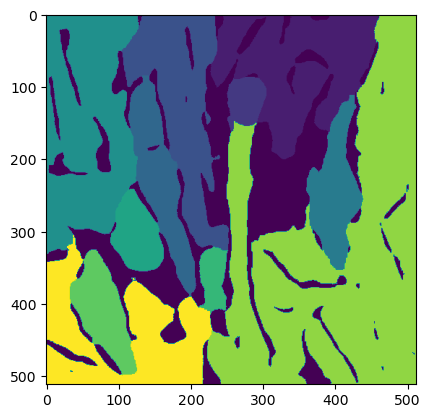

In [36]:
cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

It seems like the segmentation doesn't work quite as well for the hpa_endo image set, as the cells are not defined as well and there are large sections that are detected as one cell when they should not be. The nuclei detection worked well though. 

In [38]:
hpa = hpa_mito

Now, I'll re-run the script from 2b onward, before running the code below:

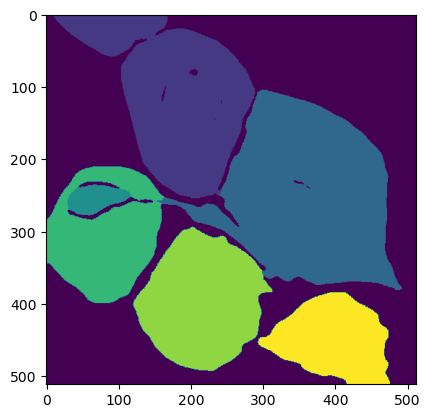

In [51]:
cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

As you can see, the hpa_mito image set works well for identifying both nuclei and cells. The mask looks good here and clearly identified the 5 prominent cells within this image

In [53]:
hpa = hpa_nucl

Now, I'll re-run the script from 2b onward, before running the code below:

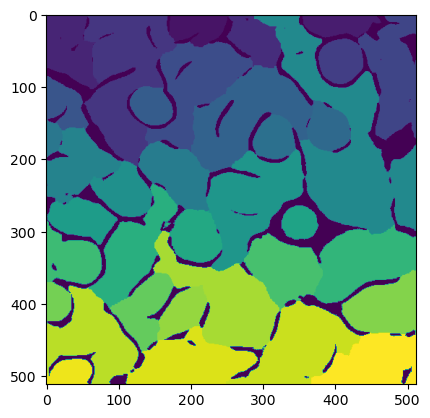

In [65]:
cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

the hpa_nucl image set works well but not as well as cyto. There are some areas where multiple cells are detected as one cell. Nucleus identification worked well though. 